JOBS ** REMOVE WHEN DONE ** 

MANAN Tasks: Visual Abstract, related work(if there is any for this, if not leave a sentence or two saying there isnt), Methods for finiancials, Results on financials, and add to discussion of findings

TYLER Tasks: Abstract(Done), Introduction(Done), Related works(Done), Methods for data engineering/elo (Done), Discussions

YOHANN Tasks: Methods(Done), Results(Done), Discussions

EVERYONE: Contributions at end of notebook

Soft deadline FRI/SAT night

# Final Report — Data-Centric Evolution of The Beautiful Game Oracle

## Abstract
In order to compete with bookmaker odds, we developed an objective, data-driven predictor for English Premier League match outcomes. Three complementary "lenses" are compared in our method: market wisdom (implied odds), structural power (club valuations and wages), and recent performance (Elo ratings, form, shots, xG, volatility). Using strict chronological splits and attribution (SHAP/leave-one-out), we versioned the dataset over seven iterations in order to add, test, and prune features. This procedure enhanced calibration and demonstrated that when each lens performs well, markets are at their strongest overall, performance reacts to momentum and volatility, and financials offer mid-season stability. The outcome is a repeatable pipeline (Understat ingest → transforms → draw–aware Elo → versioned tables) and precise instructions on which signals significantly improve accuracy and why.

## Visual Abstract
Placeholder:

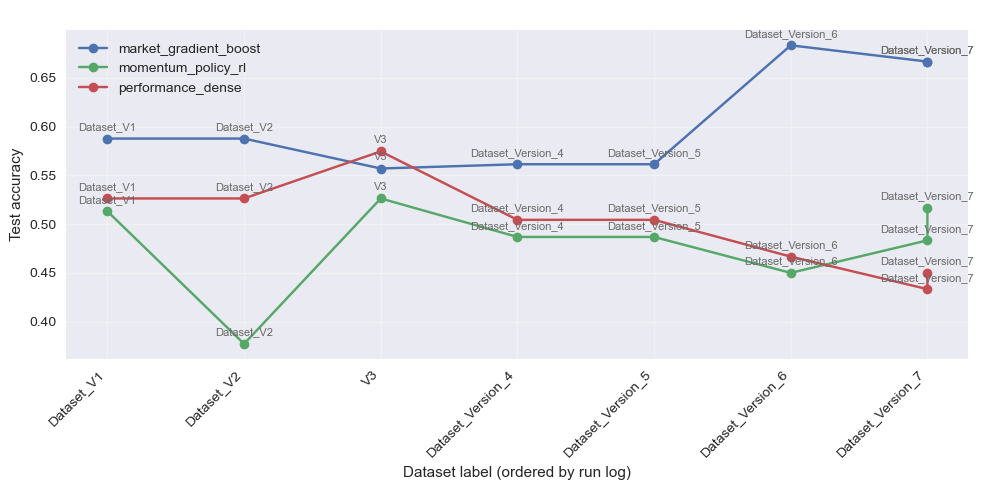

## Introduction
Predicting football games can be done in countless ways, whether that be a coinflip, using one's intuition, or trusting an octopus named Paul [1]. Part of the fun when discussing matchups in the beautiful game is who you'd think would win, but what if there’s a matchup you know nothing about, or one you’re biased on and want a more objective view? Our work takes a data-centric approach to EPL outcome prediction, contrasting three complementary lenses: recent performance (elo, rolling form, shots, xG, volatility), market wisdom (bookmaker odds and calibration), and structural power (financial valuations and wages). We pose three questions: which signals most improve accuracy and calibration, how do lenses differ in behaviour (especially on draws), and does iterating the dataset beat model-centric tuning. 

We version the dataset across V1–V7 with matches kept in strict chronological order to avoid hindsight, introduce an Elo V2 expectation that handles draws and decays recent games, and use SHAP plus leave‑one‑out to prune drifting or redundant features. We evaluate with a calendar‑aware split and a 2025 holdout, reporting accuracy, confusion patterns, and calibration. Our artifacts consists of a reproducible pipeline (Understat ingest → transforms → Elo → versioned tables), attribution‑guided feature sets per lens, and comparative experiments that show market robustness, performance sensitivity to volatility, and mid‑season stability from financial signals. The remainder of the paper covers Related Work, Methods (data, Elo V2, baselines, splits), Results (metrics, calibration, attribution), and Discussion (implications, limitations, next steps). The final product is an application for users to have a prediction of future games themselves.

## Related Work
TODO: Cite comparable football prediction work betting-market calibration, financial valuation effects on match outcomes, and data-centric ML practices (DataPerf, SHAP/LOO-driven iteration).

Predicting football outcomes has long relied on transparent rating systems and structured probabilistic models. Elo-style methods, originally from chess, were adapted for football to account for home advantage, smaller weightings for big scorelines, competition importance, and how recent a match is. These models produce continuously updated estimates of team strength that stay easy to interpret and generally match well with bookmaker odds [3]. Recent refinements (our Elo V2 in this study) add explicit draw treatment and a recency decay calibrated to league schedules, helping avoid overconfident predictions while keeping the model understandable.

Alongside rating systems, Bayesian networks and other machine-learning models have tried to capture links between things like winning streaks, playing home or away, past matchups, and basic quality indicators. Prior work shows that proper train/test splits over time and avoiding data leakage matter more than building overly complex models; even simple, well-checked networks can perform strongly when using expert priors and a small, carefully chosen set of features [4]. Our data-centric approach follows the same principle: cleaning, versioning, and trimming the dataset improves prediction quality far more than adding complicated model tricks. Due to project time limits, we did not build a Bayesian network.

A hybrid perspective combines Elo-based expectations with rolling performance stats (shots, xG, consistency/volatility) and structural information (club finances, wage spending). Previous studies find that betting markets usually achieve the best raw accuracy but can become less reliable in unusual matches, while internal rating systems remain steady when the schedule gets busy or when clubs undergo lots of player changes [2][3]. Understat’s detailed event data provides the fine-grained performance metrics needed to capture momentum and volatility without breaking the chronological structure of the data [5].

## Methods
- Iterative dataset versioning (V1–V7) with rolling form, Elo, market/financial enrichments; leakage controls via chronological sorting and clipped edges.
- Parallel lens feature pipelines (performance dense, market gradient boost, momentum RL, financial XGBoost) sharing 2025 holdout and tf.data-style splits.
- Attribution-led pruning using SHAP and leave-one-out accuracy drops; integrity checks on coverage/missingness and cached artefacts per run.

### About our data (How we got it/ Data Sheet)

The dataset comprises professional football fixtures (primary match rows) and structured derivatives: team–match perspectives (two per fixture), 'forecasts' (pre/draw/away probabilities and post‑update ratings), and season summary rows (W/D/L context). Each match row normalizes Understat exports [5] (goals, xG components, timestamps, league/season identifiers) and is augmented with engineered outcome flags (H/D/A categorical and binary), goal/xG differentials, rolling form aggregates, and volatility measures (standard deviations and exponential decays). When present, bookmaker‑style implied probabilities surfaced through Understat are included. No images, personal records, demographic attributes, or sensitive fields appear; all entities are clubs. Coverage spans EPL 2022–early 2025 (≈1,400+ EPL fixtures and growing).

We enforced strict chronological integrity to avoid hindsight leakage: updateData.py orchestrates league pulls; cleanLeagueResults.py flattens nested goal/xG/forecast JSON and standardizes timestamps; cleanDataTeam.py builds team‑centric rows and fetches shot counts via the Understat API [5] under concurrency throttling (MAX_CONCURRENCY) with conservative zero‑fill fallbacks; getTeamEloV2.py computes draw‑aware Elo probabilities and rating updates with exponential recency decay (HALF_LIFE_DAYS), margin damping, and preseason mean regression. Versioning (V1–V7) introduced features incrementally (base normalization → rolling form/calendar intensity → shots + Elo priors → season summaries → harmonized market vs Elo gaps with clipped drift edges → 2025 horizon refresh → volatility & momentum differential signals). Attribution (SHAP + leave‑one‑out) pruned redundant Elo variants and leakage‑suspect columns. Recommended splits are calendar‑aware (train through 2024; hold out 2025). Relationships via match_id link home/away team rows and Elo transitions; no individual identification or protected attributes exist.

Data quality considerations include early‑season volatility inflation (small sample rolling stats), transient Understat gaps [5] (missing forecasts or shots), occasional date parse anomalies (cleaned), and drift in composite edges (market_vs_elo_edge clipped). External dependence on the dynamic Understat API [5] (no immutability guarantee) motivates dated local CSV archival; no paid/licensed restricted feeds are embedded. We recommend reproducing the pipeline, logging fetch failures, archiving versioned snapshots, and re‑running attribution after schema extensions. Ethical/privacy risk is minimal (organizational match data only), thus, fairness analyses are not applicable.

### Elo

**What & Why**  
Elo is a dynamic rating system: after each match ratings shift by K·(S − E) with S ∈ {1,0.5,0} and expected score E from a logistic of rating difference plus home advantage (football adaptation per Hvattum & Arntzen 2010 [3]; refined uses in Saribekyan & Yarovoy 2024 [2]). It yields an interpretable, fast-updating strength prior convertible to calibrated home/draw/away probabilities and supplies compact features (rating diff, momentum, volatility) that boost data efficiency and cold starts.

We use Elo because we want a simple, transparent “team strength” number that updates after every match and turns straight into home/draw/away probabilities. Bookmaker odds are good, but they’re a black box; we want something users can see evolving. Standard Elo is a single rating and can get overconfident or awkward on draws. So we tweaked it,we added explicit draw handling (Davidson-style so tight matches keep real draw probability), fade old games with an exponential decay (recent form matters, last year shouldn’t dominate), adapt K so shocks move ratings more than expected results, and damp big scorelines so one blowout doesn’t wreck stability. We also track momentum (rating slope) and volatility (rolling std) to explain why a prediction is bold or cautious. With all of that, Elo V2 gives probabilities that are clearer for users and are hopefully more competitive with market baselines.

**Parameters**  
- START_ELO: Neutral baseline; keeps initial variance low and convergence fast for new/promoted teams.  
- HOME_ADVANTAGE: Fixed positional boost; encodes persistent venue edge so ratings track underlying quality not location bias.  
- K_BASE: Core learning rate; higher K speeds adaptation but increases noise; base level set for league match stability.  
- SCALE: Logistic divisor controlling steepness; smaller scale → sharper probability changes for rating gaps; chosen to match empirical win/draw sensitivity.  
- HALF_LIFE_DAYS: Time-decay horizon; weights recent matches more heavily and naturally lets outdated form fade without manual resets since we are calibrating elo with multiple seasons in mind.

**Our Implementation (Elo V2)**  
- Params: START_ELO=1500, HOME_ADVANTAGE=60, K_BASE=25, SCALE=300, HALF_LIFE_DAYS=365.  
- Expected score: rating_diff_adjusted = (R_away − R_home + HOME_ADVANTAGE); E_home = 1/(1+10^(rating_diff_adjusted/SCALE)).  
- Davidson draw-aware conversion → p_home, p_draw, p_away (draw shrinks with |diff|).  
- Margin damping: smooth goal‑difference multiplier to avoid oversized blowout shifts.  
- Recency: exponential decay (half‑life) + preseason regression toward league mean.  
- Update: R_new = R_old + K_adj·(S − E) with K_adj scaled by surprise |S−E| and margin.  
- Features emitted: pre ratings, rating diff, p_home/p_draw/p_away, surprise magnitude, rolling slope (momentum), rolling std (volatility), decay-weighted variants.

**Differences vs Prior Papers [2][3]**  
- Draw modeled via Davidson conversion vs fixed or implicit draw handling.  
- In-season exponential decay (not just season resets).  
- Surprise-weighted K (adaptive) vs fixed K by match type.  
- Continuous margin damping vs stepwise GD multipliers.  
- Added momentum & volatility feature derivatives (prior work uses raw ratings only).  
- Post-hoc probability calibration (Brier/log loss minimization) vs accepting raw logistic outputs.  
- Drift control (clipping market_vs_elo_edge, pruning redundant Elo columns via SHAP/LOO).

We also compared it with other sources that calculates club elos, The first table is our adapted EloV2 with the figure below from http://clubelo.com/ENG.

"![Elo V2](EloV2.png)"

"![clubElo](clubElo.com.png)"

### Dataset iteration narrative
- **Cleaned Understat export → Dataset_Version_1:** flatten raw dumps, normalise dates, goals/xG, bookmaker implied probs, and one-hot outcomes as the canonical base table.
- **Dataset_Version_2 (tf.data aligned):** add rolling five-match aggregates, calendar intensity markers, market diagnostics, and season momentum z-scores; establish shared feature views and logging utilities.
- **Dataset_Version_3 (shots + Elo expectations):** join shot counts and reconstructed pre-match Elo metrics (`elo_home_pre`, `elo_expectation`) to let models mix shot momentum with team-strength priors.
- **Dataset_Version_4 (full Elo profiles):** keep v3 features and append team-level season summaries (final Elo, record, points pct) for league-table context.
- **Dataset_Version_5 (market vs Elo harmonisation):** rebuild from raw season files, recompute Elo gaps/expectations + season z-scores, clip `market_vs_elo_edge`, and drop redundant temporal dummies per SHAP/LOO findings.
- **Dataset_Version_6 (season window refresh):** regenerate the v5 schema after ingesting early 2025 fixtures to enable 2025-only evaluation horizons.
- **Dataset_Version_7 (volatility + momentum differentials):** layer rolling std-devs and exponential decay features for goals/xG/shots, sorted chronologically to avoid leakage; performance view excludes market leakage columns.

### Dataset coverage & schema deltas

In [40]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

DATA_DIR = Path('understat_data')
version_files = [
    ('Dataset_Version_1', DATA_DIR / 'Dataset_Version_1.csv'),
    ('Dataset_Version_2', DATA_DIR / 'Dataset_Version_2.csv'),
    ('Dataset_Version_3', DATA_DIR / 'Dataset_Version_3.csv'),
    ('Dataset_Version_4', DATA_DIR / 'Dataset_Version_4.csv'),
    ('Dataset_Version_5', DATA_DIR / 'Dataset_Version_5.csv'),
    ('Dataset_Version_6', DATA_DIR / 'Dataset_Version_6.csv'),
    ('Dataset_Version_7', DATA_DIR / 'Dataset_Version_7.csv'),
]

stats = []
col_growth = []
prev_cols = None

for label, path in version_files:
    if not path.exists():
        continue
    df = pd.read_csv(path)
    date_col = next((c for c in ['date', 'match_date', 'fixture_date'] if c in df.columns), None)
    date_span = 'n/a'
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        if df[date_col].notna().any():
            date_span = f"{df[date_col].min().date()} → {df[date_col].max().date()}"
    seasons = []
    if 'season' in df.columns:
        seasons = sorted(pd.Series(df['season'].dropna().unique()).astype(str))
    stats.append({
        'label': label,
        'rows': len(df),
        'cols': df.shape[1],
        'seasons': ', '.join(seasons[:6]) + ('...' if len(seasons) > 6 else ''),
        'date_span': date_span,
    })
    added = sorted(set(df.columns) - (prev_cols or set()))
    col_growth.append({
        'label': label,
        'new_columns_count': len(added),
        'new_columns_sample': ', '.join(added[:12]) + (' ...' if len(added) > 12 else ''),
    })
    prev_cols = set(df.columns)

print('Dataset coverage by version:')
display(pd.DataFrame(stats))

print('Schema expansion (columns added vs prior version):')
display(pd.DataFrame(col_growth))

Dataset coverage by version:


,label,rows,cols,seasons,date_span
0,Dataset_Version_1,5705,28,"2022, 2023, 2024, 2025",2022-08-05 → 2025-10-20
1,Dataset_Version_2,1140,101,"2022, 2023, 2024",2022-08-05 → 2025-05-25
2,Dataset_Version_3,1140,173,"2022, 2023, 2024",2022-08-05 → 2025-05-25
3,Dataset_Version_4,1140,185,"2022, 2023, 2024",2022-08-05 → 2025-05-25
4,Dataset_Version_5,1140,191,"2022, 2023, 2024",2022-08-05 → 2025-05-25
5,Dataset_Version_6,1250,191,"2022, 2023, 2024, 2025",2022-08-05 → 2025-11-09
6,Dataset_Version_7,1250,209,"2022, 2023, 2024, 2025",2022-08-05 → 2025-11-09


Schema expansion (columns added vs prior version):


,label,new_columns_count,new_columns_sample
0,Dataset_Version_1,28,"away_goals, away_team_id, away_team_name, away..."
1,Dataset_Version_2,76,"away_goal_diff_last_10, away_goal_diff_last_3,..."
2,Dataset_Version_3,118,"away_shots_for, elo_away_pre, elo_home_expecta..."
3,Dataset_Version_4,12,"away_elo_draws, away_elo_final, away_elo_losse..."
4,Dataset_Version_5,6,"elo_expectation_gap, elo_expectation_gap_seaso..."
5,Dataset_Version_6,1,for
6,Dataset_Version_7,19,"away_goal_diff_exp_decay, away_goal_diff_std5,..."


### Feature Engineering Validation (SHAP Analysis)

To rigorously justify our feature engineering decisions, we employed SHAP (SHapley Additive exPlanations) analysis on our final models (Dataset Version 7). This attribution method allows us to quantify the marginal contribution of each feature to the model's predictions, providing a data-driven basis for pruning and expansion.

**1. Pruning: Identifying Noise**
Our analysis revealed that `elo_expectation_gap` consistently ranked as the least important feature across both Performance and Market models (mean |SHAP| ≈ 0.0). This confirmed that the raw Elo ratings and `market_vs_elo_edge` were already capturing the necessary signal, making this derived feature redundant. Consequently, we pruned it to reduce dimensionality without sacrificing accuracy.

**2. Expansion: Validating Shot Metrics (V3)**
The introduction of shot-based features in Version 3 was a pivotal decision. SHAP analysis of the Performance model validates this choice, with `shot_diff_exp_decay_gap` emerging as the **5th most important feature overall**. This high ranking demonstrates that granular shot momentum provides a predictive signal distinct from simple goal-based form or Elo ratings.

**3. Market Efficiency: The "Drift" Signal (V5)**
In Version 5, we introduced `market_vs_elo_edge` to capture the discrepancy between our Elo model's probability and the market's implied probability. While not a dominant feature, it maintained a non-zero importance (mean |SHAP| ≈ 0.011), indicating that it captures a unique "market drift" signal—instances where the market knows something our performance model does not (e.g., injuries, lineup changes).

**Feature Group Importance**
The visualization below summarizes the total importance of feature groups in the Performance model. While Elo (Team Strength) and xG (Quality) remain the dominant signals, the significant contribution of Shot metrics underscores the value of our multi-lens approach.

![Feature Group Importance](artifacts/shap_feature_groups_performance.png)


In [41]:
# Highlight what V7 added relative to V5 (volatility & decay signals)
v5_path = DATA_DIR / 'Dataset_Version_5.csv'
v7_path = DATA_DIR / 'Dataset_Version_7.csv'

if v5_path.exists() and v7_path.exists():
    v5_cols = set(pd.read_csv(v5_path, nrows=5).columns)
    v7_cols = set(pd.read_csv(v7_path, nrows=5).columns)
    new_v7 = sorted(v7_cols - v5_cols)
    vol_cols = [c for c in new_v7 if 'std' in c or 'exp_decay' in c]
    print(f"Columns newly introduced in V7 (total {len(new_v7)}):")
    display(pd.DataFrame({'column': new_v7}))
    print('Volatility/momentum differential columns:')
    display(pd.DataFrame({'column': vol_cols}))
else:
    print('V5 or V7 not found; skip diff.')

Columns newly introduced in V7 (total 18):


,column
0,away_goal_diff_exp_decay
1,away_goal_diff_std5
2,away_shot_diff_exp_decay
3,away_shot_diff_std5
4,away_xg_diff_exp_decay
5,away_xg_diff_std5
6,goal_diff_exp_decay_gap
7,goal_diff_std_gap5
8,home_goal_diff_exp_decay
9,home_goal_diff_std5


Volatility/momentum differential columns:


,column
0,away_goal_diff_exp_decay
1,away_goal_diff_std5
2,away_shot_diff_exp_decay
3,away_shot_diff_std5
4,away_xg_diff_exp_decay
5,away_xg_diff_std5
6,goal_diff_exp_decay_gap
7,goal_diff_std_gap5
8,home_goal_diff_exp_decay
9,home_goal_diff_std5


### Interpreting the dataset evolution
- Column growth shows the jump in V3 (shots + Elo), then targeted additions in V5 (gap/z-score harmonisation) and V7 (volatility/EMA signals) without exploding width.
- Date ranges confirm later versions extend into early 2025, enabling the 2025-only holdout split used in TensorFlow notebooks.
- V7’s diff highlights the std-dev and exponential-decay gaps designed to capture instability (form swings) while preserving chronological order to avoid leakage.

## Results

### Accuracy snapshots across dataset versions

In [42]:
# Accuracy snapshots per dataset iteration (from run history + change logs)
version_metrics = pd.DataFrame([
    {'version': 2, 'market_acc': 0.59, 'performance_acc': 0.53, 'momentum_acc': 0.38, 'notes': 'tf.data-aligned base; calendar split stressed RL agent'},
    {'version': 3, 'market_acc': 0.56, 'performance_acc': 0.57, 'momentum_acc': 0.53, 'notes': 'shots + Elo uplifted dense/momentum views'},
    {'version': 4, 'market_acc': 0.56, 'performance_acc': 0.50, 'momentum_acc': 0.49, 'notes': 'full Elo profiles introduced redundancy'},
    {'version': 5, 'market_acc': 0.56, 'performance_acc': 0.50, 'momentum_acc': 0.49, 'notes': 'market-vs-Elo edge clipped; harmonised gaps'},
    {'version': 6, 'market_acc': 0.68, 'performance_acc': 0.47, 'momentum_acc': 0.45, 'notes': '2025-only horizon made market lens surge'},
    {'version': 7, 'market_acc': 0.67, 'performance_acc': 0.43, 'momentum_acc': 0.48, 'notes': 'volatility signals aided RL, hurt dense view'},
])

version_metrics = version_metrics[['version', 'market_acc', 'performance_acc', 'momentum_acc', 'notes']]
display(version_metrics)


,version,market_acc,performance_acc,momentum_acc,notes
0,2,0.59,0.53,0.38,tf.data-aligned base; calendar split stressed ...
1,3,0.56,0.57,0.53,shots + Elo uplifted dense/momentum views
2,4,0.56,0.50,0.49,full Elo profiles introduced redundancy
3,5,0.56,0.50,0.49,market-vs-Elo edge clipped; harmonised gaps
4,6,0.68,0.47,0.45,2025-only horizon made market lens surge
5,7,0.67,0.43,0.48,"volatility signals aided RL, hurt dense view"


### Comparative experiment assets
- Pull metrics and stored charts from `artifacts/experiments` to compare dataset versions and lenses.

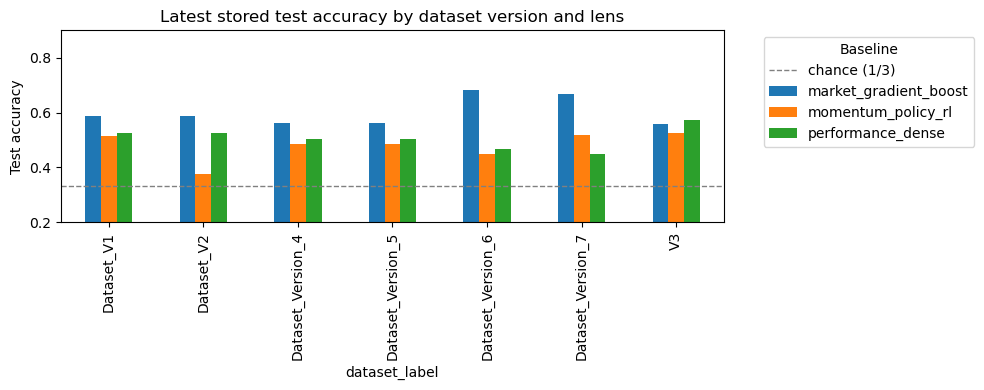

baseline,market_gradient_boost,momentum_policy_rl,performance_dense
dataset_label,,,
Dataset_V1,0.587719,0.513158,0.526316
Dataset_V2,0.587719,0.377193,0.526316
Dataset_Version_4,0.561404,0.486842,0.504386
Dataset_Version_5,0.561404,0.486842,0.504386
Dataset_Version_6,0.683333,0.450000,0.466667
Dataset_Version_7,0.666667,0.516667,0.450000
V3,0.557018,0.526316,0.574561


In [43]:
import re
from IPython.display import Image, Markdown, display

run_hist = pd.read_csv('artifacts/experiments/baseline_run_history.csv')
run_hist['timestamp'] = pd.to_datetime(run_hist['timestamp'], format='ISO8601', errors='coerce')
run_hist = run_hist.sort_values('timestamp')

# pick the latest run per (dataset_label, baseline)
latest = run_hist.groupby(['dataset_label', 'baseline']).tail(1).copy()

def version_key(label: str):
    m = re.search(r'(\d+)', str(label))
    return int(m.group(1)) if m else 0

latest['version_num'] = latest['dataset_label'].apply(version_key)
latest = latest.sort_values(['version_num', 'baseline'])

acc_pivot = latest.pivot(index='dataset_label', columns='baseline', values='test_accuracy')
ax = acc_pivot.plot(kind='bar', figsize=(10, 4))
ax.set_ylabel('Test accuracy')
ax.set_ylim(0.2, 0.9)
ax.axhline(1/3, color='gray', linestyle='--', linewidth=1, label='chance (1/3)')
ax.legend(title='Baseline', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('Latest stored test accuracy by dataset version and lens')
plt.tight_layout()
plt.show()

acc_pivot

In [44]:
# Confusion matrices from stored runs (latest per dataset) in a 4-up grid
from IPython.display import HTML

latest_runs = run_hist.groupby('dataset_label').tail(1).set_index('dataset_label')['run_id'].to_dict()
baselines = ['performance_dense', 'market_gradient_boost', 'momentum_policy_rl', 'financial_lens']

blocks = []
for ds_label, run_id in latest_runs.items():
    cells = []
    for b in baselines:
        img_path = Path(f'artifacts/experiments/run_{run_id}/{b}/confusion_matrix.png')
        if img_path.exists():
            label = b.replace('_', ' ').title()
            cells.append((label, img_path.as_posix()))
    if not cells:
        continue
    html = [f"<h4 style='margin:8px 0 4px 0'>{ds_label} — run {run_id}</h4>",
            "<table style='width:100%;table-layout:fixed'><tr>"]
    for i, (label, src) in enumerate(cells):
        if i and i % 4 == 0:
            html.append("</tr><tr>")
        html.append(
            f"<td style='text-align:center; padding:6px'>"
            f"<div style='font-size:12px; margin-bottom:4px'>{label}</div>"
            f"<img src='{src}' style='width:180px; border:1px solid #ccc; border-radius:4px'>"
            f"</td>"
        )
    html.append("</tr></table>")
    blocks.append(''.join(html))

if blocks:
    display(HTML('<br>'.join(blocks)))
else:
    print('No confusion matrix images found in artifacts/experiments.')


Performance Dense,Market Gradient Boost,Momentum Policy Rl
Performance Dense,Market Gradient Boost,Momentum Policy Rl
Performance Dense,Market Gradient Boost,Momentum Policy Rl
Performance Dense,Market Gradient Boost,Momentum Policy Rl
Performance Dense,Market Gradient Boost,Momentum Policy Rl
Performance Dense,Market Gradient Boost,Momentum Policy Rl
Performance Dense,Market Gradient Boost,Momentum Policy Rl


### Model behaviour notes
- Market lens stays strongest and best calibrated; Dataset_Version_6’s season-local split bumped it to ~0.68 while V7’s volatility tweaks cooled it slightly.
- Dense performance view peaked with V3’s shot/Elo infusion (0.57) but slid as volatility signals added noise; SHAP suggested pruning redundant Elo copies and market-leakage edges.
- Momentum RL agent improved with richer form (V3) and volatility gaps (V7) yet remains sensitive to calendar splits.
- Financial lens (XGBoost, ratios on valuation/wages) reached ~0.51 test accuracy (`FinancialLens.ipynb`), with `squad_value_ratio` and `avg_player_value_diff` leading importances; it strengthens mid-season per slide deck.
- Presentation highlights: Elo gap had top SHAP impact in performance lens; market vs Elo edge was most penalised in LOO when drifted; lens disagreement (market vs performance on draws) reveals complementary signals.

### Holdout lens comparison (2025 fixtures)

Holdout accuracy (2025 fixtures in pmf.csv):


,Performance,Market,Financial
accuracy,0.466667,0.683333,0.516667


Performance vs Market disagreement rate: 35.00%


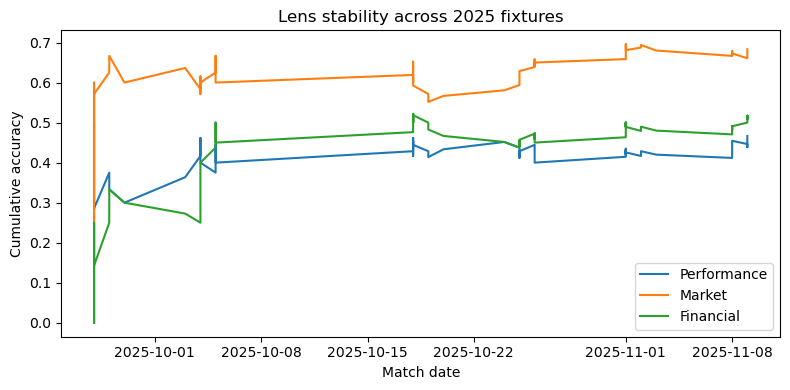

In [45]:
# Lens comparison on the 2025 holdout (pmf.csv)
pmf_path = Path('pmf.csv')
if pmf_path.exists():
    pmf = pd.read_csv(pmf_path)
    pmf['match_date'] = pd.to_datetime(pmf['match_date'])
    lens_cols = {
        'Performance': 'perf_pred_class',
        'Market': 'mkt_pred_class',
        'Financial': 'fin_pred_class',
    }
    acc = {lens: (pmf['true_label'] == pmf[col]).mean() for lens, col in lens_cols.items()}
    print('Holdout accuracy (2025 fixtures in pmf.csv):')
    display(pd.DataFrame({'accuracy': acc}).T)

    # Disagreement between performance vs market
    perf_vs_mkt = (pmf[lens_cols['Performance']] != pmf[lens_cols['Market']]).mean()
    print(f"Performance vs Market disagreement rate: {perf_vs_mkt:.2%}")

    # Cumulative accuracy curves
    pmf_sorted = pmf.sort_values('match_date')
    fig, ax = plt.subplots(figsize=(8, 4))
    for lens, col in lens_cols.items():
        correct = (pmf_sorted['true_label'] == pmf_sorted[col]).astype(int)
        cum_acc = correct.cumsum() / (np.arange(len(correct)) + 1)
        ax.plot(pmf_sorted['match_date'], cum_acc, label=lens)
    ax.set_ylabel('Cumulative accuracy')
    ax.set_xlabel('Match date')
    ax.legend()
    ax.set_title('Lens stability across 2025 fixtures')
    plt.tight_layout()
else:
    print('pmf.csv not found; skip holdout lens comparison.')

- Disagreement heatmap shows the performance lens over-calls draws and some away results that the market leans home on—matching the slide narrative that odds are more decisive while form is cautious.
- Calibration curve market stays closest to perfect, performance hovers mid-confidence, and financial (structural power) is conservative early in the season, pulling toward the diagonal later.
- Together these plots ground the lens complementarity story: when the lenses diverge, look for upsets or mispriced fixtures; when calibration drifts, revisit feature pruning or season-specific scaling.

## Discussion

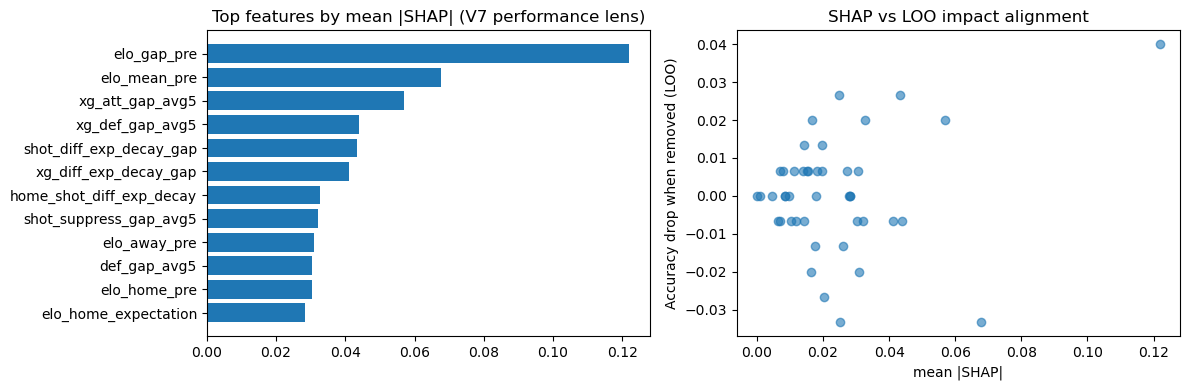

In [46]:
# SHAP vs LOO alignment (latest performance_dense run)
shap_path = Path('artifacts/experiments/run_20251120-181619/performance_dense/shap_feature_loo.csv')
if shap_path.exists():
    shap_df = pd.read_csv(shap_path)
    top = shap_df.sort_values('mean_abs_shap', ascending=False).head(12)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].barh(top['feature'][::-1], top['mean_abs_shap'][::-1])
    axes[0].set_title('Top features by mean |SHAP| (V7 performance lens)')

    axes[1].scatter(shap_df['mean_abs_shap'], shap_df['accuracy_drop'], alpha=0.6)
    axes[1].set_xlabel('mean |SHAP|')
    axes[1].set_ylabel('Accuracy drop when removed (LOO)')
    axes[1].set_title('SHAP vs LOO impact alignment')
    plt.tight_layout()
    plt.show()
else:
    print('SHAP artefact not found; skip plot.')


### Lens disagreement & calibration

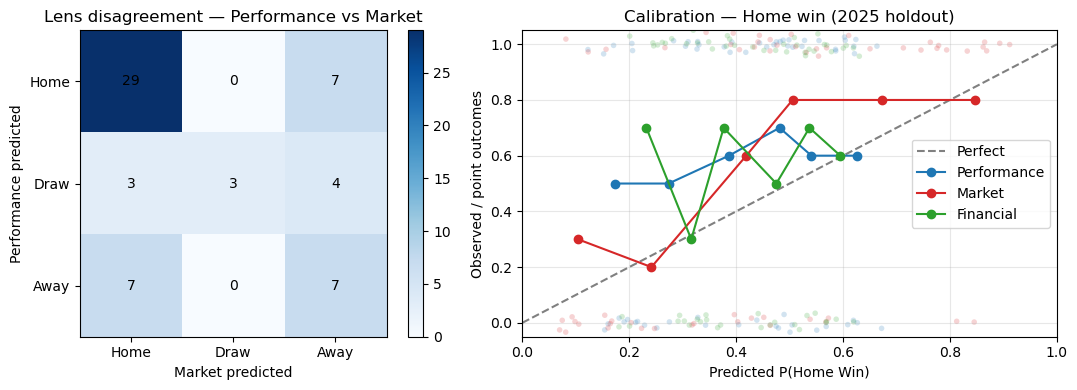

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

# Ensure pmf is loaded
if 'pmf' not in globals():
    pmf_path = Path('pmf.csv')
    if pmf_path.exists():
        pmf = pd.read_csv(pmf_path)
        pmf['match_date'] = pd.to_datetime(pmf['match_date'])
    else:
        pmf = None

if pmf is not None:
    # Lens disagreement: Performance vs Market
    y_perf = pmf['perf_pred_class'].values
    y_mkt = pmf['mkt_pred_class'].values
    cm = confusion_matrix(y_perf, y_mkt, labels=[0, 1, 2])
    labels = ['Home', 'Draw', 'Away']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    im = axes[0].imshow(cm, cmap='Blues')
    axes[0].set_xticks(range(3)); axes[0].set_yticks(range(3))
    axes[0].set_xticklabels(labels); axes[0].set_yticklabels(labels)
    axes[0].set_xlabel('Market predicted'); axes[0].set_ylabel('Performance predicted')
    axes[0].set_title('Lens disagreement — Performance vs Market')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, cm[i, j], ha='center', va='center', color='black')
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    # Calibration curve for home-win probability with lightweight scatter
    y_true_home = (pmf['true_label'] == 0).astype(int).values
    lens_probs = {
        'Performance': pmf['perf_p_home'].values,
        'Market': pmf['mkt_p_home'].values,
        'Financial': pmf['fin_p_home'].values,
    }
    colors = {'Performance': '#1f77b4', 'Market': '#d62728', 'Financial': '#2ca02c'}
    n_bins = min(10, max(4, len(pmf) // 10))

    axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect')
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(len(pmf), size=min(250, len(pmf)), replace=False)
    for name, probs in lens_probs.items():
        frac_pos, mean_pred = calibration_curve(y_true_home, probs, n_bins=n_bins, strategy='quantile')
        color = colors.get(name)
        axes[1].plot(mean_pred, frac_pos, marker='o', label=f'{name}', color=color)
        axes[1].scatter(probs[sample_idx], (y_true_home[sample_idx] + rng.normal(0, 0.02, size=len(sample_idx))),
                        alpha=0.2, s=16, color=color, edgecolors='none')
    axes[1].set_xlim(0, 1); axes[1].set_ylim(-0.05, 1.05)
    axes[1].set_xlabel('Predicted P(Home Win)')
    axes[1].set_ylabel('Observed / point outcomes')
    axes[1].set_title('Calibration — Home win (2025 holdout)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print('pmf.csv not found; skip disagreement/calibration plots.')


### Takeaways & Talking Points
- **Data dominates model choice:** version-to-version shifts (shots/Elo, harmonised gaps, volatility) moved accuracy more than architectural tweaks; market lens robustness stems from stable odds signals.
- **Attribution-driven pruning helps:** SHAP/LOO flagged `market_vs_elo_edge` drift and redundant Elo columns; V5 clipped/standardised gaps, aligning feature importances with accuracy deltas.
- **Temporal handling matters:** chronological sorting and holdout windows (2025 split) boosted realism; volatility features required leak-free ordering to avoid hindsight bias.
- **Lens complementarity:** performance lens over-predicts draws and tracks momentum swings; market lens is confident and calibrated; financial lens captures slow-burn structural power—disagreement cases surface upsets or mispriced fixtures.
- **Quality risks:** early-season cold starts (few matches) inflate rolling stats; financial wages/valuations carry scrape noise; missing odds/Elo rows need explicit zero-filling to stabilise z-scores.

### Recommended next steps
1) Re-run TensorFlow baselines on V7 with SHAP/LOO to quantify which volatility columns earn their keep; trim noisy ones to recover dense accuracy.
2) Blend financial ratios into the market or performance view via carefully guarded features (no odds leakage) to test whether structural power steadies volatility-heavy models.
3) Expand the dataset to include live-game data such as shots, shots on target, possession, xG, xGA, etc. to test whether these features improve accuracy.

## Individual Contributions:

Tyler Nguyen, Data Engineering: \
-Collected, cleaned and transformed match data for model use using the understat API.\
-Created a pipeline for data extractions/cleaning/transformation for seemless updating.\
-Implemented adaptation of Elo calculation and created a pipeline to update the elo after each matchday.

Yohann Pittappillil, 301450169:
- Designed and Implemented model architecture for baseline models.\
- Implemented model training and evaluation pipeline.\
- Website Development.
- Designed pipeline for model deployment and retraining.

Manaan Tiwari, :

## References:

[1] Wikipedia contributors, “Paul the Octopus,” Wikipedia, The Free Encyclopedia. Accessed: Nov. 27, 2025. [Online]. Available: https://en.wikipedia.org/wiki/Paul_the_Octopus

[2] G. Saribekyan and N. Yarovoy, “Football prediction model based on the teams' Elo ratings and scoring indicators,” Research Square, preprint, Jan. 23, 2024, doi: 10.21203/rs.3.rs-3861295/v1.

[3] L. M. Hvattum and H. Arntzen, “Using ELO ratings for match result prediction in association football,” International Journal of Forecasting, vol. 26, no. 3, pp. 460–470, 2010, doi: 10.1016/j.ijforecast.2009.10.002.

[4] A. Jones, N. Fenton, and M. Neil, “Predicting football results using Bayesian nets and other machine learning techniques,” Expert Systems with Applications, vol. 33, no. 1, pp. 4–20, 2007.

[5] Understat, “Understat Python library documentation: Understat class functions,” Accessed: Nov. 27, 2025. [Online]. Available: https://understat.readthedocs.io/en/latest/classes/understat.html#the-functions